In [1]:
import math
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
T = math.ceil(1500000 / 32)
k = 3

In [3]:
batch_size = 16

In [4]:
x = torch.rand(batch_size, 3)
y = torch.randint(k, (batch_size, ))

x_bce = torch.rand(batch_size, 1)
y_bce = torch.randint(2, (batch_size, 1)).float()

In [5]:
from tsa import TrainingSignalAnnealing, TSAScheduleCrossEntropy, TSAScheduleBinaryCrossEntropy

In [6]:
ce_tsa = TSAScheduleCrossEntropy(total_steps=T, n_classes=k)
bce_tsa = TSAScheduleBinaryCrossEntropy(total_steps=T, n_classes=2, current_step=T//3)

In [7]:
ce_tsa

TSAScheduleCrossEntropy(
  (criterion): CrossEntropyLoss()
  (activation): Softmax()
)

In [8]:
bce_tsa

TSAScheduleBinaryCrossEntropy(
  (criterion): BCELoss()
  (activation): Sigmoid()
)

In [9]:
correct_x, correct_y = ce_tsa(x, y)

In [10]:
correct_x_bce, correct_y_bce = bce_tsa(x_bce, y_bce)

In [11]:
correct_x.shape, correct_y.shape

(torch.Size([11, 3]), torch.Size([11]))

In [12]:
correct_x_bce.shape, correct_y_bce.shape

(torch.Size([14, 1]), torch.Size([14, 1]))

In [13]:
ce = torch.nn.CrossEntropyLoss()
bce = torch.nn.BCELoss()

In [39]:
ce(x, y)

tensor(1.2148)

In [40]:
ce(correct_x, correct_y)

tensor(1.3821)

In [41]:
bce(x_bce, y_bce)

tensor(0.8899)

In [42]:
bce(correct_x_bce, correct_y_bce)

tensor(0.9949)

In [43]:
torch.nn.functional.cross_entropy(x, y, reduction='none').sum()

tensor(19.4370)

In [44]:
torch.nn.functional.cross_entropy(correct_x, correct_y, reduction='none').sum()

tensor(15.2033)

In [45]:
torch.nn.functional.cross_entropy(x, y, reduction='none').mean()

tensor(1.2148)

In [46]:
torch.nn.functional.cross_entropy(correct_x, correct_y, reduction='none').mean()

tensor(1.3821)

In [47]:
torch.nn.functional.binary_cross_entropy(x_bce, y_bce, reduction='none').sum()

tensor(14.2390)

In [48]:
torch.nn.functional.binary_cross_entropy(correct_x_bce, correct_y_bce, reduction='none').sum()

tensor(13.9280)

In [49]:
torch.nn.functional.cross_entropy(x, y, reduction='none').mean()

tensor(1.2148)

In [50]:
torch.nn.functional.cross_entropy(correct_x, correct_y, reduction='none').mean()

tensor(1.3821)

In [52]:
x_bce.shape, correct_x_bce.shape

(torch.Size([16, 1]), torch.Size([14, 1]))

In [20]:
torch.cat([1 - x_bce.sigmoid(), x_bce.sigmoid()], 1)

tensor([[0.4493, 0.5507],
        [0.4477, 0.5523],
        [0.3907, 0.6093],
        [0.3113, 0.6887],
        [0.2787, 0.7213],
        [0.3697, 0.6303],
        [0.3147, 0.6853],
        [0.4481, 0.5519],
        [0.3461, 0.6539],
        [0.3035, 0.6965],
        [0.4484, 0.5516],
        [0.3018, 0.6982],
        [0.3802, 0.6198],
        [0.4817, 0.5183],
        [0.2798, 0.7202],
        [0.4948, 0.5052]])

In [21]:
v = torch.cat([1 - x_bce.sigmoid(), x_bce.sigmoid()], 1)[torch.arange(x_bce.size(0)), y_bce.squeeze().long()] < 0.6

In [22]:
v

tensor([1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1], dtype=torch.uint8)

In [31]:
torch.cat([x_bce.sigmoid(), y_bce], dim=1)

tensor([[0.5507, 0.0000],
        [0.5523, 0.0000],
        [0.6093, 1.0000],
        [0.6887, 0.0000],
        [0.7213, 1.0000],
        [0.6303, 0.0000],
        [0.6853, 1.0000],
        [0.5519, 1.0000],
        [0.6539, 1.0000],
        [0.6965, 0.0000],
        [0.5516, 0.0000],
        [0.6982, 0.0000],
        [0.6198, 1.0000],
        [0.5183, 0.0000],
        [0.7202, 1.0000],
        [0.5052, 1.0000]])

In [32]:
torch.cat([x_bce[v].sigmoid(), y_bce[v]], dim=1)

tensor([[0.5507, 0.0000],
        [0.5523, 0.0000],
        [0.6887, 0.0000],
        [0.6303, 0.0000],
        [0.5519, 1.0000],
        [0.6965, 0.0000],
        [0.5516, 0.0000],
        [0.6982, 0.0000],
        [0.5183, 0.0000],
        [0.5052, 1.0000]])

In [30]:
x_bce[v].sigmoid()

tensor([[0.5507],
        [0.5523],
        [0.6887],
        [0.6303],
        [0.5519],
        [0.6965],
        [0.5516],
        [0.6982],
        [0.5183],
        [0.5052]])

In [28]:
y_bce

tensor([[0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.]])

In [26]:
y_bce[v]

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.]])

In [36]:
y_bce

tensor([[0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.]])

In [28]:
correct_y_bce

tensor([[0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.]])

In [ ]:
y_bce

In [34]:
torch.cat([x_bce, 1 - x_bce], dim=1)

tensor([[0.1324, 0.8676],
        [0.1363, 0.8637],
        [0.7959, 0.2041],
        [0.9757, 0.0243],
        [0.6859, 0.3141],
        [0.3005, 0.6995],
        [0.9738, 0.0262],
        [0.9899, 0.0101],
        [0.1301, 0.8699],
        [0.0762, 0.9238],
        [0.3902, 0.6098],
        [0.1348, 0.8652],
        [0.1915, 0.8085],
        [0.6585, 0.3415],
        [0.4191, 0.5809],
        [0.7086, 0.2914],
        [0.9216, 0.0784],
        [0.8812, 0.1188],
        [0.9269, 0.0731],
        [0.2811, 0.7189],
        [0.2264, 0.7736],
        [0.3745, 0.6255],
        [0.3502, 0.6498],
        [0.3994, 0.6006],
        [0.2342, 0.7658],
        [0.0527, 0.9473],
        [0.2389, 0.7611],
        [0.6894, 0.3106],
        [0.2485, 0.7515],
        [0.9192, 0.0808],
        [0.4663, 0.5337],
        [0.9507, 0.0493]])

In [32]:
1 - x_bce

tensor([[0.8676],
        [0.8637],
        [0.2041],
        [0.0243],
        [0.3141],
        [0.6995],
        [0.0262],
        [0.0101],
        [0.8699],
        [0.9238],
        [0.6098],
        [0.8652],
        [0.8085],
        [0.3415],
        [0.5809],
        [0.2914],
        [0.0784],
        [0.1188],
        [0.0731],
        [0.7189],
        [0.7736],
        [0.6255],
        [0.6498],
        [0.6006],
        [0.7658],
        [0.9473],
        [0.7611],
        [0.3106],
        [0.7515],
        [0.0808],
        [0.5337],
        [0.0493]])

In [4]:
from tsa import TrainingSignalAnnealing

In [15]:
ce_tsa = TrainingSignalAnnealing(total_steps=T, n_classes=k)
bce_tsa = TrainingSignalAnnealing(total_steps=T, n_classes=2, current_step=T//3)

In [16]:
bce_tsa.current_step

15625

In [19]:
correct_x, correct_y = ce_tsa.get_correct_samples_cross_entropy(x, y)

In [20]:
correct_x

tensor([[0.1655, 0.1124, 0.6736],
        [0.4703, 0.0212, 0.1635],
        [0.0638, 0.0061, 0.6030],
        [0.5278, 0.4959, 0.9445],
        [0.9938, 0.0848, 0.0258],
        [0.6418, 0.7603, 0.4106],
        [0.0829, 0.0215, 0.0387],
        [0.3007, 0.4660, 0.3120],
        [0.9687, 0.7835, 0.8985],
        [0.7599, 0.7998, 0.9703],
        [0.7600, 0.4346, 0.3496],
        [0.9362, 0.2449, 0.3165],
        [0.7883, 0.2650, 0.0989],
        [0.7308, 0.1244, 0.0143],
        [0.7175, 0.9298, 0.9245],
        [0.5261, 0.1299, 0.1020],
        [0.8989, 0.1776, 0.4456],
        [0.1235, 0.8560, 0.7115],
        [0.6820, 0.3300, 0.5027],
        [0.8560, 0.2297, 0.0569],
        [0.0821, 0.8648, 0.4496]])

In [21]:
correct_y

tensor([1, 1, 0, 0, 1, 2, 1, 2, 1, 0, 2, 2, 2, 1, 0, 2, 2, 0, 1, 1, 2])

In [22]:
correct_x.shape

torch.Size([21, 3])

In [23]:
x_bce = torch.rand(32, 1)
y_bce = torch.randint(2, (32, )).float()

In [24]:
x_bce

tensor([[0.4854],
        [0.4679],
        [0.0448],
        [0.0484],
        [0.4808],
        [0.2458],
        [0.0348],
        [0.6903],
        [0.3724],
        [0.7216],
        [0.6712],
        [0.1187],
        [0.3018],
        [0.1883],
        [0.9564],
        [0.4665],
        [0.9013],
        [0.2297],
        [0.7373],
        [0.9831],
        [0.2315],
        [0.1688],
        [0.8485],
        [0.9629],
        [0.4858],
        [0.6135],
        [0.1187],
        [0.5083],
        [0.5408],
        [0.3372],
        [0.9907],
        [0.5063]])

In [25]:
correct_x_bce, correct_y_bce = bce_tsa.get_correct_samples_binary_cross_entropy(x_bce, y_bce)

In [26]:
correct_x_bce

tensor([0.4854, 0.4679, 0.0448, 0.0484, 0.4808, 0.2458, 0.0348, 0.6903, 0.3724,
        0.6712, 0.1187, 0.3018, 0.1883, 0.4665, 0.2297, 0.2315, 0.1688, 0.4858,
        0.6135, 0.1187, 0.5083, 0.5408, 0.3372, 0.5063])

In [27]:
correct_y_bce

tensor([0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1.,
        1., 1., 1., 1., 1., 1.])

In [16]:
torch.sigmoid(x_bce)

tensor([[0.7281],
        [0.5358],
        [0.5951],
        [0.6268],
        [0.5771],
        [0.6615],
        [0.7106],
        [0.6849],
        [0.6844],
        [0.6230],
        [0.6951],
        [0.7293],
        [0.6937],
        [0.6838],
        [0.6793],
        [0.5656],
        [0.6919],
        [0.6158],
        [0.7205],
        [0.6729],
        [0.5971],
        [0.6725],
        [0.7210],
        [0.5942],
        [0.6208],
        [0.6855],
        [0.6791],
        [0.7154],
        [0.5906],
        [0.6569],
        [0.7095],
        [0.6292]])

In [7]:
correct_x.shape

torch.Size([16, 3])

In [8]:
criterion = torch.nn.CrossEntropyLoss()

In [9]:
criterion(x, y)

tensor(1.0943)

In [10]:
criterion(correct_x, correct_y)

tensor(0.8846)

In [13]:
x = torch.rand(32, 1)
y = torch.randint(2, (32, ))

In [44]:
y = y.float()

In [45]:
x

tensor([[7.3594e-01],
        [7.0448e-01],
        [1.2676e-01],
        [2.9827e-01],
        [5.2283e-01],
        [5.4664e-01],
        [4.2617e-01],
        [7.4621e-02],
        [4.0153e-02],
        [4.1965e-01],
        [2.7685e-01],
        [4.1835e-01],
        [3.9072e-01],
        [5.1403e-01],
        [9.5017e-01],
        [5.0444e-01],
        [1.8969e-01],
        [5.1329e-01],
        [4.6291e-01],
        [5.0513e-01],
        [7.1544e-01],
        [7.3596e-01],
        [1.6324e-01],
        [8.1298e-01],
        [8.7116e-01],
        [7.1066e-01],
        [8.9045e-01],
        [4.8012e-04],
        [2.0487e-01],
        [1.0946e-01],
        [3.4341e-01],
        [2.1718e-01]])

In [46]:
y

tensor([0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
        0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0.])

In [47]:
torch.nn.functional.sigmoid(x)

/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor([[0.6761],
        [0.6692],
        [0.5316],
        [0.5740],
        [0.6278],
        [0.6334],
        [0.6050],
        [0.5186],
        [0.5100],
        [0.6034],
        [0.5688],
        [0.6031],
        [0.5965],
        [0.6258],
        [0.7212],
        [0.6235],
        [0.5473],
        [0.6256],
        [0.6137],
        [0.6237],
        [0.6716],
        [0.6761],
        [0.5407],
        [0.6927],
        [0.7050],
        [0.6705],
        [0.7090],
        [0.5001],
        [0.5510],
        [0.5273],
        [0.5850],
        [0.5541]])

In [48]:
[torch.arange(x.size(0)), y]

[tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]),
 tensor([0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
         0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0.])]

In [49]:
ind = torch.nn.functional.sigmoid(x) > 0.6

In [50]:
x[ind]

tensor([0.7359, 0.7045, 0.5228, 0.5466, 0.4262, 0.4197, 0.4183, 0.5140, 0.9502,
        0.5044, 0.5133, 0.4629, 0.5051, 0.7154, 0.7360, 0.8130, 0.8712, 0.7107,
        0.8904])

In [52]:
correct_x = x[ind]

In [53]:
correct_y = y[ind.squeeze()]

In [54]:
bce = torch.nn.BCELoss()

In [55]:
l = bce(correct_x, correct_y)

In [56]:
l

tensor(0.8632)

In [29]:
ind

tensor([[1],
        [1],
        [0],
        [0],
        [1],
        [1],
        [1],
        [0],
        [0],
        [1],
        [0],
        [1],
        [0],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0]], dtype=torch.uint8)

In [18]:
torch.nn.functional.sigmoid(x)[torch.arange(x.size(0)), y] > 0.6

RuntimeError: index 1 is out of bounds for dim with size 1

In [3]:
from tsa import TrainingSignalAnnealing, TSAScheduleCrossEntropy

In [4]:
tsa = TSAScheduleCrossEntropy(total_steps=T, n_classes=k, current_step=25000)

In [6]:
loss = tsa(x, y)

In [7]:
loss

(tensor([], size=(0, 3)), tensor([], dtype=torch.int64))

In [8]:
c = loss[0]

In [10]:
c.size(0)

0

In [7]:
c = torch.nn.CrossEntropyLoss()

In [8]:
loss

tensor(1.1830)

In [9]:
c(x, y)

tensor(1.1830)

In [11]:
tsa.softmax(x)

tensor([[0.2763, 0.3981, 0.3256],
        [0.5201, 0.2526, 0.2273],
        [0.3419, 0.2956, 0.3625],
        [0.3320, 0.3898, 0.2783],
        [0.2613, 0.4685, 0.2701],
        [0.2748, 0.2571, 0.4681],
        [0.3689, 0.3952, 0.2359],
        [0.3072, 0.3808, 0.3120],
        [0.4417, 0.2922, 0.2661],
        [0.2125, 0.3492, 0.4383],
        [0.3602, 0.4103, 0.2296],
        [0.2535, 0.2942, 0.4523],
        [0.2842, 0.3519, 0.3639],
        [0.5047, 0.3066, 0.1887],
        [0.2432, 0.4634, 0.2934],
        [0.3116, 0.3177, 0.3707],
        [0.2547, 0.2733, 0.4719],
        [0.2923, 0.3537, 0.3540],
        [0.3562, 0.3838, 0.2599],
        [0.4687, 0.2688, 0.2626],
        [0.4192, 0.2460, 0.3348],
        [0.4429, 0.2773, 0.2798],
        [0.3447, 0.3870, 0.2683],
        [0.2402, 0.3120, 0.4477],
        [0.2171, 0.5632, 0.2198],
        [0.4080, 0.3531, 0.2389],
        [0.3373, 0.3935, 0.2692],
        [0.3279, 0.2622, 0.4099],
        [0.1739, 0.3906, 0.4355],
        [0.414

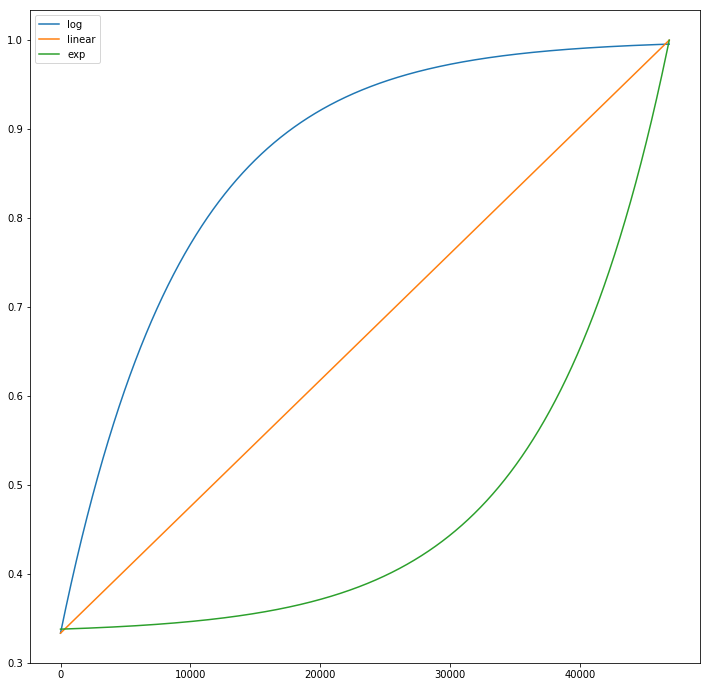

In [4]:
tsa_linear = TrainingSignalAnnealing(total_steps=T, n_classes=k)
tsa_log = TrainingSignalAnnealing(total_steps=T, n_classes=k, schedule_type='log')
tsa_exp = TrainingSignalAnnealing(total_steps=T, n_classes=k, schedule_type='exp')

plt.figure(figsize=(12, 12))
plt.plot([p for p in tsa_log], label='log')
plt.plot([p for p in tsa_linear], label='linear')
plt.plot([p for p in tsa_exp], label='exp')
plt.legend()

In [5]:
import torch

In [6]:
class NN(torch.nn.Module):
    
    def __init__(self, in_features=128, out_features=3):
        
        super(NN, self).__init__()
        
        self.linear = torch.nn.Linear(in_features=in_features, out_features=out_features)
        self.softmax = torch.nn.Softmax(dim=1)
        
    def forward(self, x):
        
        x = self.linear(x)
        x = self.softmax(x)
        
        return x

In [7]:
model = NN()

In [8]:
model

NN(
  (linear): Linear(in_features=128, out_features=3, bias=True)
  (softmax): Softmax()
)

In [9]:
model.state_dict()

OrderedDict([('linear.weight',
              tensor([[ 0.0514,  0.0774, -0.0051,  0.0142, -0.0567,  0.0317, -0.0883,  0.0132,
                        0.0080,  0.0746, -0.0077, -0.0762, -0.0487,  0.0178, -0.0696, -0.0785,
                        0.0130,  0.0506, -0.0868,  0.0601, -0.0364,  0.0485, -0.0746,  0.0216,
                        0.0289,  0.0704,  0.0583, -0.0701,  0.0287, -0.0410, -0.0546, -0.0433,
                       -0.0875, -0.0873,  0.0386, -0.0114,  0.0630, -0.0240,  0.0735, -0.0457,
                       -0.0176,  0.0212,  0.0642,  0.0013,  0.0673,  0.0845, -0.0163, -0.0083,
                       -0.0153, -0.0386, -0.0523,  0.0423,  0.0513,  0.0141, -0.0018, -0.0713,
                       -0.0034, -0.0025,  0.0071, -0.0504, -0.0343, -0.0477, -0.0055, -0.0207,
                       -0.0288, -0.0418,  0.0404, -0.0784, -0.0577,  0.0010, -0.0686, -0.0294,
                        0.0083, -0.0256,  0.0866, -0.0593,  0.0316,  0.0314,  0.0022,  0.0872,
                   

In [23]:
optimizer = torch.optim.Adam(model.parameters())

In [24]:
criterion = torch.nn.NLLLoss()

In [25]:
x = torch.rand(32, 128)
y = torch.randint(k, (32, ))
p = 0.35

In [26]:
pred = model(x)

In [41]:
selected_pred = pred[pred[torch.arange(pred.size(0)), y] < p]

In [42]:
selected_pred

tensor([[0.3211, 0.3712, 0.3077],
        [0.3714, 0.3604, 0.2682],
        [0.2730, 0.4086, 0.3184],
        [0.3090, 0.3298, 0.3612],
        [0.3311, 0.3857, 0.2832],
        [0.2622, 0.4204, 0.3174],
        [0.2421, 0.4973, 0.2606],
        [0.2786, 0.3365, 0.3850],
        [0.3529, 0.3607, 0.2864],
        [0.3006, 0.3143, 0.3851],
        [0.2845, 0.3797, 0.3358],
        [0.1855, 0.4294, 0.3851],
        [0.3091, 0.3495, 0.3414],
        [0.2679, 0.3523, 0.3797],
        [0.2814, 0.3457, 0.3729],
        [0.2770, 0.4619, 0.2612],
        [0.2927, 0.3342, 0.3731],
        [0.2202, 0.4531, 0.3266],
        [0.2976, 0.4207, 0.2818],
        [0.3373, 0.3456, 0.3172]], grad_fn=<IndexBackward>)

In [40]:
selected_y = y[pred[torch.arange(pred.size(0)), y] < p]

In [47]:
tsa_exp.calculate_step(0)

0.3378252979993903

In [43]:
def selected_samples(predictions, p):
    
    return predictions[torch.arange(predictions.size(0)), y] < p

In [44]:
selected_samples(pred, p)

tensor([0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
        1, 1, 1, 0, 1, 1, 1, 1], dtype=torch.uint8)

In [45]:
y[selected_samples(pred, p)]

tensor([0, 2, 0, 0, 0, 2, 2, 0, 2, 1, 0, 0, 1, 0, 0, 2, 1, 0, 0, 1])

In [30]:
selected_y

tensor([1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 2, 1])

In [31]:
optimizer.zero_grad()

In [32]:
loss = criterion(selected_pred, selected_y)

In [33]:
loss.backward()

In [34]:
optimizer.step()

In [36]:
v = model.state_dict()

In [37]:
v

OrderedDict([('linear.weight',
              tensor([[ 5.0351e-02,  7.6374e-02, -6.1370e-03,  1.3174e-02, -5.7739e-02,
                        3.0674e-02, -8.9349e-02,  1.2147e-02,  7.0357e-03,  7.3549e-02,
                       -8.7033e-03, -7.7263e-02, -4.9699e-02,  1.6781e-02, -7.0646e-02,
                       -7.9541e-02,  1.1989e-02,  4.9599e-02, -8.7877e-02,  5.9105e-02,
                       -3.7389e-02,  4.7476e-02, -7.5665e-02,  2.0573e-02,  2.7897e-02,
                        6.9415e-02,  5.7267e-02, -7.1164e-02,  2.7676e-02, -4.2023e-02,
                       -5.5622e-02, -4.4291e-02, -8.8519e-02, -8.8310e-02,  3.7552e-02,
                       -1.2426e-02,  6.2034e-02, -2.5075e-02,  7.2467e-02, -4.6769e-02,
                       -1.8616e-02,  2.0224e-02,  6.3121e-02,  2.3987e-04,  6.6316e-02,
                        8.3504e-02, -1.7356e-02, -9.3007e-03, -1.6375e-02, -3.9642e-02,
                       -5.3289e-02,  4.1312e-02,  5.0308e-02,  1.3050e-02, -2.8637e-03,
 

In [39]:
v['linear.weight'].shape

torch.Size([3, 128])

In [143]:
pred

tensor([[0.3626, 0.2230, 0.4144],
        [0.3067, 0.2320, 0.4613],
        [0.3019, 0.3498, 0.3483],
        [0.2965, 0.2797, 0.4239],
        [0.3263, 0.3053, 0.3684],
        [0.3007, 0.2824, 0.4169],
        [0.3886, 0.2399, 0.3715],
        [0.4059, 0.3171, 0.2770],
        [0.3648, 0.2109, 0.4242],
        [0.3910, 0.2198, 0.3892],
        [0.3369, 0.2468, 0.4163],
        [0.3215, 0.2779, 0.4006],
        [0.3571, 0.2976, 0.3453],
        [0.3506, 0.2942, 0.3552],
        [0.3834, 0.2187, 0.3979],
        [0.2464, 0.2883, 0.4653],
        [0.3443, 0.2758, 0.3799],
        [0.3320, 0.2631, 0.4050],
        [0.3167, 0.2815, 0.4018],
        [0.3581, 0.3018, 0.3401],
        [0.3578, 0.2170, 0.4252],
        [0.3663, 0.2304, 0.4033],
        [0.3501, 0.2194, 0.4305],
        [0.2665, 0.2521, 0.4814],
        [0.3263, 0.2802, 0.3934],
        [0.3863, 0.2381, 0.3756],
        [0.3897, 0.2557, 0.3546],
        [0.2879, 0.3028, 0.4092],
        [0.4228, 0.2625, 0.3147],
        [0.281

In [144]:
y

tensor([2, 1, 1, 0, 1, 2, 2, 2, 2, 2, 1, 0, 2, 0, 2, 1, 0, 2, 1, 0, 2, 0, 0, 2,
        2, 0, 0, 1, 2, 0, 2, 0])

In [145]:
def NLLLoss(logs, targets):
    out = torch.zeros_like(targets, dtype=torch.float)
    for i in range(len(targets)):
        out[i] = logs[i][targets[i]]
    return out


def FEF(logs, targets):
    
    out = torch.diag(logs[:,targets])
    
    return out

In [146]:
c = NLLLoss(pred, y)

In [147]:
c = FEF(pred, y)

In [148]:
FEF(pred, y)

tensor([0.4144, 0.2320, 0.3498, 0.2965, 0.3053, 0.4169, 0.3715, 0.2770, 0.4242,
        0.3892, 0.2468, 0.3215, 0.3453, 0.3506, 0.3979, 0.2883, 0.3443, 0.4050,
        0.2815, 0.3581, 0.4252, 0.3663, 0.3501, 0.4814, 0.3934, 0.3863, 0.3897,
        0.3028, 0.3147, 0.2819, 0.4287, 0.4261], grad_fn=<DiagBackward>)

In [149]:
NLLLoss(pred, y)

tensor([0.4144, 0.2320, 0.3498, 0.2965, 0.3053, 0.4169, 0.3715, 0.2770, 0.4242,
        0.3892, 0.2468, 0.3215, 0.3453, 0.3506, 0.3979, 0.2883, 0.3443, 0.4050,
        0.2815, 0.3581, 0.4252, 0.3663, 0.3501, 0.4814, 0.3934, 0.3863, 0.3897,
        0.3028, 0.3147, 0.2819, 0.4287, 0.4261], grad_fn=<CopySlices>)

In [150]:
torch.diag(pred[:, y])

tensor([0.4144, 0.2320, 0.3498, 0.2965, 0.3053, 0.4169, 0.3715, 0.2770, 0.4242,
        0.3892, 0.2468, 0.3215, 0.3453, 0.3506, 0.3979, 0.2883, 0.3443, 0.4050,
        0.2815, 0.3581, 0.4252, 0.3663, 0.3501, 0.4814, 0.3934, 0.3863, 0.3897,
        0.3028, 0.3147, 0.2819, 0.4287, 0.4261], grad_fn=<DiagBackward>)

In [151]:
pred[torch.arange(pred.size(0)), y]

tensor([0.4144, 0.2320, 0.3498, 0.2965, 0.3053, 0.4169, 0.3715, 0.2770, 0.4242,
        0.3892, 0.2468, 0.3215, 0.3453, 0.3506, 0.3979, 0.2883, 0.3443, 0.4050,
        0.2815, 0.3581, 0.4252, 0.3663, 0.3501, 0.4814, 0.3934, 0.3863, 0.3897,
        0.3028, 0.3147, 0.2819, 0.4287, 0.4261], grad_fn=<IndexBackward>)

In [152]:
c = pred[torch.arange(pred.size(0)), y]

In [153]:
c > p

tensor([1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 0, 0, 1, 1], dtype=torch.uint8)

In [154]:
v = pred[pred[torch.arange(pred.size(0)), y] > p]

In [155]:
v

tensor([[0.3626, 0.2230, 0.4144],
        [0.3019, 0.3498, 0.3483],
        [0.3007, 0.2824, 0.4169],
        [0.3886, 0.2399, 0.3715],
        [0.3648, 0.2109, 0.4242],
        [0.3910, 0.2198, 0.3892],
        [0.3571, 0.2976, 0.3453],
        [0.3506, 0.2942, 0.3552],
        [0.3834, 0.2187, 0.3979],
        [0.3443, 0.2758, 0.3799],
        [0.3320, 0.2631, 0.4050],
        [0.3581, 0.3018, 0.3401],
        [0.3578, 0.2170, 0.4252],
        [0.3663, 0.2304, 0.4033],
        [0.3501, 0.2194, 0.4305],
        [0.2665, 0.2521, 0.4814],
        [0.3263, 0.2802, 0.3934],
        [0.3863, 0.2381, 0.3756],
        [0.3897, 0.2557, 0.3546],
        [0.3083, 0.2630, 0.4287],
        [0.4261, 0.1851, 0.3888]], grad_fn=<IndexBackward>)

In [169]:
p

0.3378252979993903

In [ ]:
pred.select()

In [91]:
pred[:, y]

tensor([[0.4628, 0.1951, 0.3421,  ..., 0.1951, 0.3421, 0.4628],
        [0.3171, 0.3344, 0.3485,  ..., 0.3344, 0.3485, 0.3171],
        [0.2421, 0.4490, 0.3089,  ..., 0.4490, 0.3089, 0.2421],
        ...,
        [0.2472, 0.3902, 0.3625,  ..., 0.3902, 0.3625, 0.2472],
        [0.2207, 0.4100, 0.3693,  ..., 0.4100, 0.3693, 0.2207],
        [0.2866, 0.2091, 0.5043,  ..., 0.2091, 0.5043, 0.2866]])

In [ ]:
pred

In [75]:
pred[y, :]

tensor([[0.4628, 0.3421, 0.1951],
        [0.2421, 0.3089, 0.4490],
        [0.3171, 0.3485, 0.3344],
        [0.2421, 0.3089, 0.4490],
        [0.4628, 0.3421, 0.1951],
        [0.2421, 0.3089, 0.4490],
        [0.4628, 0.3421, 0.1951],
        [0.4628, 0.3421, 0.1951],
        [0.2421, 0.3089, 0.4490],
        [0.2421, 0.3089, 0.4490],
        [0.2421, 0.3089, 0.4490],
        [0.2421, 0.3089, 0.4490],
        [0.2421, 0.3089, 0.4490],
        [0.3171, 0.3485, 0.3344],
        [0.3171, 0.3485, 0.3344],
        [0.2421, 0.3089, 0.4490],
        [0.4628, 0.3421, 0.1951],
        [0.2421, 0.3089, 0.4490],
        [0.2421, 0.3089, 0.4490],
        [0.3171, 0.3485, 0.3344],
        [0.4628, 0.3421, 0.1951],
        [0.2421, 0.3089, 0.4490],
        [0.3171, 0.3485, 0.3344],
        [0.2421, 0.3089, 0.4490],
        [0.4628, 0.3421, 0.1951],
        [0.2421, 0.3089, 0.4490],
        [0.3171, 0.3485, 0.3344],
        [0.4628, 0.3421, 0.1951],
        [0.2421, 0.3089, 0.4490],
        [0.242

In [61]:
y.gather(0, )

TypeError: gather(): argument 'index' (position 2) must be Tensor, not int

In [59]:
predaa

tensor([[0.4628, 0.3421, 0.1951],
        [0.2421, 0.3089, 0.4490],
        [0.3171, 0.3485, 0.3344],
        [0.2421, 0.3089, 0.4490],
        [0.4628, 0.3421, 0.1951],
        [0.2421, 0.3089, 0.4490],
        [0.4628, 0.3421, 0.1951],
        [0.4628, 0.3421, 0.1951],
        [0.2421, 0.3089, 0.4490],
        [0.2421, 0.3089, 0.4490],
        [0.2421, 0.3089, 0.4490],
        [0.2421, 0.3089, 0.4490],
        [0.2421, 0.3089, 0.4490],
        [0.3171, 0.3485, 0.3344],
        [0.3171, 0.3485, 0.3344],
        [0.2421, 0.3089, 0.4490],
        [0.4628, 0.3421, 0.1951],
        [0.2421, 0.3089, 0.4490],
        [0.2421, 0.3089, 0.4490],
        [0.3171, 0.3485, 0.3344],
        [0.4628, 0.3421, 0.1951],
        [0.2421, 0.3089, 0.4490],
        [0.3171, 0.3485, 0.3344],
        [0.2421, 0.3089, 0.4490],
        [0.4628, 0.3421, 0.1951],
        [0.2421, 0.3089, 0.4490],
        [0.3171, 0.3485, 0.3344],
        [0.4628, 0.3421, 0.1951],
        [0.2421, 0.3089, 0.4490],
        [0.242

In [56]:
z, _ = pred.max(dim=1)

In [57]:
z[z > p]

tensor([0.4628, 0.3485, 0.4490, 0.4387, 0.3668, 0.3930, 0.3932, 0.4197, 0.4148,
        0.4178, 0.4015, 0.4597, 0.4513, 0.3715, 0.4090, 0.3600, 0.3667, 0.4235,
        0.4600, 0.4139, 0.4437, 0.4029, 0.4478, 0.4262, 0.4420, 0.4071, 0.3962,
        0.4176, 0.3955, 0.3902, 0.4100, 0.5043])

In [40]:
pred.select(0, [1, 5])

TypeError: select(): argument 'index' (position 2) must be int, not list

In [34]:
pred[pred > p]

tensor([0.3434, 0.3728, 0.3712, 0.4345, 0.3419, 0.3421, 0.4297, 0.4623, 0.3661,
        0.3468, 0.3488, 0.4638, 0.3988, 0.3685, 0.5089, 0.4722, 0.3819, 0.3489,
        0.4033, 0.4104, 0.3660, 0.4061, 0.3695, 0.4447, 0.4305, 0.4885, 0.3458,
        0.3631, 0.3671, 0.4365, 0.5020, 0.3728, 0.3601, 0.3653, 0.3749, 0.3579,
        0.4615, 0.3767, 0.3710, 0.3497, 0.4087, 0.3835])

In [33]:
criterion(pred, y)

tensor(-0.3363)